# Lab 2: Bag of Visual Words Image Classification

Team 3: Zuzanna Szafranowska, Claudia Baca, Quim Comas

In [27]:
import cv2
import numpy as np
import itertools
#inPython3.x:
import pickle as cPickle
#in Python2.x:
#import cPickle
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler,normalize, Normalizer,PowerTransformer
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
import time
# from sklearn.cross_validation import StratifiedKFold



Let us first read the train and test files

In [28]:
train_images_filenames = cPickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','rb'))
train_labels = cPickle.load(open('train_labels.dat','rb'))
test_labels = cPickle.load(open('test_labels.dat','rb'))

<h1>Feature extraction, descriptors</h1>

We create detectors and descriptors: SIFT, SURF, ORB

In [29]:
SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=300)
SURFdetector = cv2.xfeatures2d.SURF_create(300)
ORBdetector = cv2.ORB_create()

We choose the type of local feature detector that we want to use. 

- 1 ==> SIFT
- 2 ==> SURF
- 3 ==> ORB
- 4 ==> Dense SIFT
- 5 ==> Dense SURF


In [30]:
k = 256
#codebook size
x=4
#x = input("Enter a number to choose the local feature detector: ")
L=2
#Enter the number levels of the spatial pyramid (O to L)
norm=0
#Type of normalization of 1 L2 and 2 Power, 0 if none
step_size = 5
#step size of Dense SIFT and SURF
scale=5
#scale of Dense SIFT and SURF


In [31]:
def descriptors(gray,x):
    if(x==1):
        kpt,des=SIFTdetector.detectAndCompute(gray,None)
    if(x==2):
        kpt,des=SURFdetector.detectAndCompute(gray,None)
    if(x==3):
        kpt,des=ORBdetector.detectAndCompute(gray,None)
    if(x==4):
        kpt = [cv2.KeyPoint(x, y, scale) for y in range(0, gray.shape[0], step_size) 
                                            for x in range(0, gray.shape[1], step_size)]
        kpt,des=SIFTdetector.compute(gray,kpt)
    if(x==5):
        
        kpt = [cv2.KeyPoint(x, y, scale) for y in range(0, gray.shape[0], step_size) 
                                            for x in range(0, gray.shape[1], step_size)]
        kpt,des=SURFdetector.compute(gray,kpt)
    return kpt, des

In [32]:
#obsolete
def normalize(hist1):
    if(norm==1):
        hist2=np.linalg.norm(x, ord=2)
        normhist=hist1 / hist2
    if(norm==2):
        hist=np.linalg.norm(x, ord=2)

    return normhist       

<h1>Bow</h1>

We compute the indicated descriptor for all the train images and subsequently build a numpy array with all the descriptors stacked together, then we   compute a k-means clustering on the descriptor space, where we test 3 different codebook sizes k (64,128,256). And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [275]:
def Bow(train_images_filenames,train_labels):
    Train_descriptors = []
    Train_label_per_descriptor = []
    visual_words=[]
    for filename,labels in zip(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        
        kpt,des=descriptors(gray,x)
        
        Train_descriptors.append(des)
        
        Train_label_per_descriptor.append(labels)
    D=np.vstack(Train_descriptors)
    if(norm==1):
        transformer = Normalizer(norm = 'l2')
        temp = transformer.fit(D)
        D = temp.transform(D)
        for i in range(len(Train_descriptors)):
            Train_descriptors[i] = temp.transform(Train_descriptors[i]) 
    elif(norm==2):
        pt=PowerTransformer()
        temp=pt.fit(D)
        D=temp.transform(D)
        for i in range(len(Train_descriptors)):
            Train_descriptors[i] = temp.transform(Train_descriptors[i]) 
    codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    codebook.fit(D)
    
    visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
    for i in range(len(Train_descriptors)): 
        words=codebook.predict(Train_descriptors[i])
        visual_words[i,:]=np.bincount(words,minlength=k)
    
    return visual_words, codebook
    
    
    

In [276]:
start = time.time()
visual_words,codebook=Bow(train_images_filenames,train_labels)
end = time.time()
print('Time: {}s.'.format(str(end-start)))

Time: 204.34430313110352s.


<h1>Bow-Spatial Pyramid</h1>

We compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [290]:
def get_spatialpyramid(train_images_filenames,train_labels,l):
    Train_descriptors = []
    Train_label_per_descriptor = []
    visual_words=[]
    visualwords=[]
    if(l==0):
        for filename,labels in zip(train_images_filenames,train_labels):
            ima=cv2.imread(filename)
            gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
            kpt,des=descriptors(gray,x)
            Train_descriptors.append(des)   
        D=np.vstack(Train_descriptors)
        if(norm==1):
            transformer = Normalizer(norm = 'l2')
            temp = transformer.fit(D)
            D = temp.transform(D)
            for i in range(len(Train_descriptors)):
                Train_descriptors[i] = temp.transform(Train_descriptors[i]) 
        elif(norm==2):
            pt=PowerTransformer()
            temp=pt.fit(D)
            D=temp.transform(D)
            for i in range(len(Train_descriptors)):
                Train_descriptors[i] = temp.transform(Train_descriptors[i])  
        codebook.fit(D)
        visualwords=np.zeros((len(Train_descriptors),k),dtype=np.float32)
        for i in range(len(Train_descriptors)): 
            words=codebook.predict(Train_descriptors[i])
            visualwords[i,:]=np.bincount(words,minlength=k)
            
        visual_words=visualwords 
    else:  
        for filename,labels in zip(train_images_filenames,train_labels):
            Train_descriptors = []
            ima=cv2.imread(filename)
            gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
            wstep=np.int(gray.shape[0]/(2**(l)))
            hstep=np.int(gray.shape[1]/(2**(l)))
           
            for u in range(0,gray.shape[0],wstep):
                for f in range(0,gray.shape[1],hstep):  
                    kpt,des=descriptors(gray[u:u+hstep, f:f+wstep],x)
                    Train_descriptors.append(des)
            D=np.vstack(Train_descriptors)        
            weight = 2**(L-l) 
            if(norm==1):
                transformer = Normalizer(norm = 'l2')
                temp = transformer.fit(D)
                D = temp.transform(D)
                for i in range(len(Train_descriptors)):
                    Train_descriptors[i] =weight*temp.transform(Train_descriptors[i]) 
            elif(norm==2):
                pt=PowerTransformer()
                temp=pt.fit(D)
                D=temp.transform(D)
                for i in range(len(Train_descriptors)):
                    Train_descriptors[i] = weight*temp.transform(Train_descriptors[i])          
            visualwords=np.zeros((len(Train_descriptors),k),dtype=np.float32)    
            for i in range(len(Train_descriptors)): 
                words=codebook.predict(Train_descriptors[i])
                visualwords[i,:]=np.bincount(words,minlength=k)
            weight = 2**(L-l)           
            visual_words.append((visualwords.ravel()))     
    return visual_words,codebook
                        

In [291]:
k = 256
L=0
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
i=0
visual_wordsl0,codebookl0=get_spatialpyramid(train_images_filenames,train_labels,0);
visual_wordsl1,codebook11=get_spatialpyramid(train_images_filenames,train_labels,1);  
        
            

In [292]:
visual_words=[]
for i in range(len(visual_wordsl0)):
    visu=[]
    visu=np.append(visual_wordsl0[i],visual_wordsl1[i])
    visual_words.append(visu)



In [298]:
def get_test_spatialpyramid(test_images_filenames,l):
    Train_descriptors = []
    Train_label_per_descriptor = []
    visual_words=[]
    visualwords=[]
    if(l==0):
        for i in range(len(test_images_filenames)):
            filename=test_images_filenames[i]
            ima=cv2.imread(filename)
            gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
            kpt,des=descriptors(gray,x)
            Train_descriptors.append(des)   
        D=np.vstack(Train_descriptors)
        if(norm==1):
            transformer = Normalizer(norm = 'l2')
            temp = transformer.fit(D)
            D = temp.transform(D)
            for i in range(len(Train_descriptors)):
                Train_descriptors[i] = temp.transform(Train_descriptors[i]) 
        elif(norm==2):
            pt=PowerTransformer()
            temp=pt.fit(D)
            D=temp.transform(D)
            for i in range(len(Train_descriptors)):
                Train_descriptors[i] = temp.transform(Train_descriptors[i])  
        codebook.fit(D)
        visualwords=np.zeros((len(Train_descriptors),k),dtype=np.float32)
        for i in range(len(Train_descriptors)): 
            words=codebook.predict(Train_descriptors[i])
            visualwords[i,:]=np.bincount(words,minlength=k)
            
        visual_words=visualwords 
    else:  
        for i in range(len(test_images_filenames)):
            Train_descriptors = []
            filename=test_images_filenames[i]
            ima=cv2.imread(filename)
            gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
            wstep=np.int(gray.shape[0]/(2**(l)))
            hstep=np.int(gray.shape[1]/(2**(l)))
           
            for u in range(0,gray.shape[0],wstep):
                for f in range(0,gray.shape[1],hstep):  
                    kpt,des=descriptors(gray[u:u+hstep, f:f+wstep],x)
                    Train_descriptors.append(des)
            D=np.vstack(Train_descriptors)        
            weight = 2**(L-l) 
            if(norm==1):
                transformer = Normalizer(norm = 'l2')
                temp = transformer.fit(D)
                D = temp.transform(D)
                for i in range(len(Train_descriptors)):
                    Train_descriptors[i] =weight*temp.transform(Train_descriptors[i]) 
            elif(norm==2):
                pt=PowerTransformer()
                temp=pt.fit(D)
                D=temp.transform(D)
                for i in range(len(Train_descriptors)):
                    Train_descriptors[i] = weight*temp.transform(Train_descriptors[i])          
            visualwords=np.zeros((len(Train_descriptors),k),dtype=np.float32)    
            for i in range(len(Train_descriptors)): 
                words=codebook.predict(Train_descriptors[i])
                visualwords[i,:]=np.bincount(words,minlength=k)
            weight = 2**(L-l)           
            visual_words.append((visualwords.ravel()))     
    return visual_words,codebook


In [299]:
visual_wordsl0test,codebookl0test=get_test_spatialpyramid(test_images_filenames,0)
visual_wordsl1test,codebookl1test=get_test_spatialpyramid(test_images_filenames,1)
visual_words_test=[]
for i in range(len(visual_wordsl0test)):
    visu=[]
    visu=np.append(visual_wordsl0test[i],visual_wordsl1test[i])
    visual_words_test.append(visu)

Before applying the SVM we create the histogram intersection kernel (it is not available in the sklearn library):

In [277]:
def histogram_intersection(M,N):
    M_samples, M_features = M.shape
    N_samples, N_features = N.shape
    
    K_int= np.zeros(shape=(M_samples,N_samples),dtype= np.float)
    for i in range(M_samples):
        for j in range(N_samples):
            K_int[i,j]=np.minimum(M[i,:],N[j,:]).sum()
    
    return K_int

Creating folds for Cross-Validation

In [278]:
K_cv=3
skf = StratifiedKFold(n_splits=K_cv)

<h1>SVM kernels</h1>
In this step we add the SVM classifier to train our data. Before train our visual words, we preprocess the data standardizing the features by removing the mean and scaling to unit variance. In our implementation we can choose between different types of kernels:

- Linear Kernel --> 'linear'
- Rbf Kernel --> 'rbf'
- Polynomial Kernel --> 'poly'
- Sigmoid Kernel --> 'sigmoid'
- Histogram Intersection Kernel --> 'histogram'

In [293]:
#Choose the type of kernel (histogram by default):

Kernel= 'histogram'

stdSlr= StandardScaler().fit(visual_words)
scaled = stdSlr.transform(visual_words)
start=time.time()
if(Kernel=='linear'):
    clf= svm.SVC(kernel='linear',C=0.01,gamma=0.002)
if(Kernel=='rbf'):
    clf= svm.SVC(kernel='rbf',C=1,gamma=0.002)
if(Kernel=='poly'):
    clf= svm.SVC(kernel='poly',C=1,gamma=1)
if(Kernel=='sigmoid'):
    clf= svm.SVC(kernel='sigmoid',C=1,gamma=0.002)
if(Kernel=='histogram'): 
    clf= svm.SVC(kernel='precomputed',C=0.01) 
        
folds = list(skf.split(scaled, train_labels))
for j, (train_idx, test_idx) in enumerate(folds):
    print('\n===================FOLD=',j)
    train_labels=np.asarray(train_labels)

    scaled_train, scaled_valid = scaled[train_idx], scaled[test_idx]
    labels_train, labels_valid = train_labels[train_idx], train_labels[test_idx]

    if(Kernel=='histogram'): 
        kernel=histogram_intersection(scaled_train,scaled_train)
        clf.fit(kernel,labels_train)  
    else:
        clf.fit(scaled_train,labels_train)

    if(Kernel!='histogram'):
        accuracy = 100*clf.score(scaled_valid, labels_valid)
        print(accuracy)
end=time.time()
print('Time: {}s.'.format(str(end-start)))
        



===================FOLD= 0

===================FOLD= 1

===================FOLD= 2
Time: 50.82349109649658s.


To see the effect of K value in KNN classifier we perform a 10 fold cross validation with our training set to estimate the optimal K value. Also we represent the evolution of the accuracy for each k value to see the influence of the k value:   

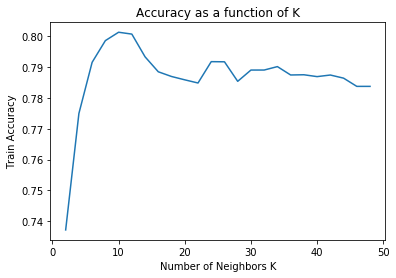

The optimal k value is 10


In [294]:
neighbors = list(filter(lambda x: x % 2 == 0, list(range(1,50))))
cv_scores = []

for kk in neighbors:
    knn = KNeighborsClassifier(n_neighbors=kk,n_jobs=-1,metric='braycurtis')
    scores = cross_val_score(knn, visual_words, train_labels, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_k = neighbors[cv_scores.index(max(cv_scores))]

plt.title('Accuracy as a function of K')
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Train Accuracy')
plt.show()
#python2.x
#print("The optimal k value is %d" % optimal_k)
#python3.x
print("The optimal k value is %d" % optimal_k)

We build a k-nn classifier and train it with the train descriptors

In [295]:
folds = skf.split(visual_words, train_labels)
knn = KNeighborsClassifier(n_neighbors=optimal_k,n_jobs=-1,metric='braycurtis')

for j, (train_idx, test_idx) in enumerate(folds):
    print('\n===================FOLD=',j)
    train_labels=np.asarray(train_labels)

    visual_words_train=[visual_words[j] for j in train_idx]
    visual_words_valid =[visual_words[j] for j in test_idx]
    labels_train, labels_valid = train_labels[train_idx], train_labels[test_idx]
    knn.fit(visual_words_train, labels_train) 
    accuracy = 100*knn.score(visual_words_valid, labels_valid)
    print(accuracy)
end=time.time()
print('Time: {}s.'.format(str(end-start)))


===================FOLD= 0
77.02060221870047

===================FOLD= 1
79.26634768740031

===================FOLD= 2
78.1701444622793
Time: 211.34826803207397s.


We end up computing the test descriptors and compute the accuracy of the model

In [ ]:
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
    kpt,des=descriptors(gray,x)
        
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k)

<h1>Evaluation</h1>

In the next step we perform the confusion matrix to evaluate our classifier with respect the 8 image classes:

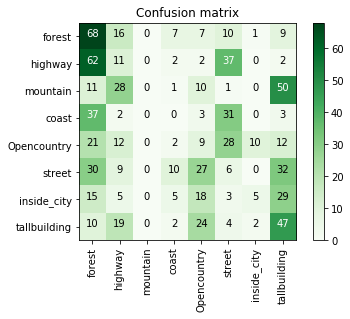

In [300]:
classes = list(set(test_labels))

if(Kernel== 'histogram'):
    predict= histogram_intersection(stdSlr.transform(visual_words_test),scaled_train)
    predictions= clf.predict(predict)
else:
    predictions= clf.predict(stdSlr.transform(visual_words_test))

conf_matrix= confusion_matrix(test_labels,predictions)
plt.figure()
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j],horizontalalignment="center",color="white" if conf_matrix[i, j] > thresh else "black")


To obtain more information about our classification we compute other mesuares like precision, recall and f-score to complement the confusion matrix and the accuracy:

In [301]:
precision, recall, fscore, support= precision_recall_fscore_support(test_labels, predictions,average='macro')

print (precision*100)
print (recall*100)
print (fscore*100)

13.10965291343058
16.464502720389902
12.931662625306528


/Users/claudiabacaperez/anaconda2/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Finally, we compute the accuracy for SVM and KNN:

In [285]:
if Kernel == 'histogram':
    accuracy_svm = 100*clf.score(predict, test_labels)
else:
    accuracy_svm = 100*clf.score(stdSlr.transform(visual_words_test), test_labels)
print(accuracy_svm)

72.73853779429987


In [286]:
accuracy_knn = 100*knn.score(visual_words_test, test_labels)
print(accuracy_knn)

72.4907063197026


<h1>Conclusions</h1>

Finally, in this last section we will expose all results and conclusions of this second lab. 


First of all, we will focus on SVM classifier and SVM Kernels. In this second lab, we have changed the KNN classifier for the SVM classifier, which has caused an improvement in terms of accuracy. To analyze in more depth the different SVM Kernels we define a initial parameters to see the effects of the different parameters. The different SVM kernels that we have implemented are: Linear kernel, Radial basis function kernel, Polynomial kernel, Sigmoid kernel and finally we have performed  


- Using initial parameters: 

    Codebook = 256;
    Trade off C=1;
    Gamma=0.002;
    Dense SIFT


| Kernels | Accuracy | CV time |
| --- | --- |--- |
| Linear |  82.2800 | 1.1656 s |
| Radial Basis Function |  84.0148 | 1.7813 s |
| Polynomial |  36.4312 | 3.1022 s |
|  Sigmoid |  82.6517 | 1.5055 s |
| Histogram intersection |  85.7496 | 61.7647 s | 

- Changing the parameter C: 

| Kernels | Accuracy, C=0.001  | Accuracy, C=0.01  | Accuracy, C=0.1 | Accuracy, C=0.5 |
| --- | --- |--- |--- |
| Linear | 81.9083 |84.0148 | 82.5278 | 82.2800 |
| Radial Basis Function | 14.6220 |  14.6220 | 14.6220 | 82.7757|
| Polynomial | 14.6220 | 14.6221 | 14.6220 | 26.2701 |
| Sigmoid | 14.6220 | 14.6220 | 14.6220 | 26.2701 |
| Histogram intersection | 81.1648| 85.9975 | 85.7496 | 85.7496 |  

- Changing the parameter gamma: 

| Kernels | Accuracy, gamma=0.0001  | Accuracy, gamma=0.01  | Accuracy, gamma=0.1 | Accuracy, gamma=1 |
| --- | --- |--- |--- |
| Linear | 82.2800 |82.2800 | 82.2800 | 82.2800 |
| Radial Basis Function | 74.3494 |  81.0408 | 14.6220 | 14.6220|
| Polynomial | 14.6220 | 79.0582 | 79.1821 | 79.1821|
| Sigmoid | 59.1078 | 71.7472 | 39.5291 | 39.9008|
| Histogram intersection | 85.7496 | 85.7496 | 85.7496 | 85.7496 | 

- Using optimal values for C and gamma from previous tables:

| Kernels | Accuracy | Final parameters | CV time |
| --- | --- |--- |--- |
| Linear |  84.0148 | C= 0.01; gamma= 0.002| 1.2401 s |
| Radial Basis Function |  84.0148 |C= 1 ; gamma= 0.002| 1.7813 s |
| Polynomial |  79.1821 |C= 1 ; gamma= 1 | 29.4810 s |
|  Sigmoid|  82.6517 | C= 1; gamma= 0.002| 1.5055 s |
| Histogram intersection |  85.9975 | C= 0.01; gamma= 0.002| 59.8077 s |


| SIFT scale | Accuracy | Execution time |
| --- | --- |--- |
| 3  |  85.1301 |  318.44 s |
| 5  |  85.9975 |  531.40 s |
| 7  |  86.6171 |  711.20 s |
| 10 |  84.5102 | 1074.69 s |



| Codebook size | Accuracy | Execution time |
| --- | --- |--- |
| 128 |  83.3952 |  462.44 s |
| 256 |  85.9975 |  531.40 s |
| 512 |  87.2366 | 1092.52 s |
| 1024|  88.3519 | 1808.38 s |



